# Price Channel Breakout Trading System

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = "../data/fw20.csv"
df = pd.read_csv(filepath, parse_dates=['Date'])
df.set_index('Date', inplace=True) # Set 'Date' as the index
df.sort_index(inplace=True) # Ensure data is sorted by date

## Trading System

### System Parameters

In [3]:
# Define date range
START_DATE = '2020-09-01'
END_DATE = '2025-12-31'

# Filter the dataset
df = df.loc[START_DATE:END_DATE].copy()

In [4]:
# Parameters
INITIAL_CAPITAL = 10000         # Initial capital in PLN

ATR_LONG = 14                   # number of sessions for slow ATR calculation
N_SESSIONS = 4                  # number of sessions for channel calculation
RISK_PERCENT = 0.04             # risk per trade
POINT_VALUE = 20                # 20 PLN per point
COMMISSION_PER_CONTRACT = 8.5   # PLN per ontract
MIN_SIZE = 1                    # minumum number of contracts
MAX_SIZE = 100                  # maximum number of contracts

### Indicator Calculation

In [5]:
# calculate ATR
df['Prev_Close'] = df['Close'].shift(1).bfill().astype(int)
df['H-L'] = (df['High'] - df['Low']).astype(int)
df['H-PC'] = abs(df['High'] - df['Prev_Close']).astype(int)
df['L-PC'] = abs(df['Low'] - df['Prev_Close']).astype(int)
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

df['ATR_long'] = df['TR'].rolling(window=ATR_LONG).mean()
df['Upper_Channel'] = df['High'].rolling(window=N_SESSIONS).max().shift(1)
df['Lower_Channel'] = df['Low'].rolling(window=N_SESSIONS).min().shift(1)

In [6]:
df.tail()

,Open,High,Low,Close,Volume,Open_Interest,Prev_Close,H-L,H-PC,L-PC,TR,ATR_long,Upper_Channel,Lower_Channel
Date,,,,,,,,,,,,,,
2025-10-08,2884,2915,2872,2900,21815,64867,2894,43,21,22,43,42.857143,2925.0,2852.0
2025-10-09,2908,2923,2894,2902,16277,66105,2900,29,23,6,29,42.642857,2921.0,2852.0
2025-10-10,2901,2913,2871,2903,21420,67875,2902,42,11,31,42,43.571429,2923.0,2852.0
2025-10-13,2880,2904,2864,2900,21828,67847,2903,40,1,39,40,44.142857,2923.0,2852.0
2025-10-14,2883,2884,2831,2872,28842,66029,2900,53,16,69,69,44.785714,2923.0,2864.0


### Signal Logic

In [7]:
# Calculate buy and sell levels

df['Buy_Level'] = (df['Upper_Channel'] + 1).astype(float)
df['Sell_Level'] = (df['Lower_Channel'] - 1).astype(float)

# Define entry conditions
df['Long_Entry'] = (df['High'] > df['Upper_Channel']) & df['Upper_Channel'].notna()
df['Short_Entry'] = (df['Low'] < df['Lower_Channel']) & df['Lower_Channel'].notna()

# --- Simulate Trades ---
# Initialize position: 1 = long, -1 = short, 0 = flat
positions = []
entry_prices = []
current_position = 0  # Current position: 1 = long, -1 = short, 0 = flat
entry_price = np.nan

for row in df.itertuples():

    # Open a new position
    if current_position == 0: 
        if row.Long_Entry:
            current_position = 1
            entry_price = row.Buy_Level
        elif row.Short_Entry:
            current_position = -1
            entry_price = row.Sell_Level

    # Flip long to short
    elif current_position == 1 and row.Short_Entry: 
        current_position = -1
        entry_price = row.Sell_Level

    # Flip short to long
    elif current_position == -1 and row.Long_Entry: 
        current_position = 1
        entry_price = row.Buy_Level

    positions.append(current_position)
    entry_prices.append(entry_price)

df['Position'] = positions
df['Entry_Price'] = entry_prices

### Result Calculation

In [ ]:
# --- Initialization ---
df['Daily_Pts'] = np.nan
df['Daily_PnL'] = np.nan
df['Position_Size'] = np.nan
df['Capital'] = np.nan

capital = INITIAL_CAPITAL
capital_list = [capital]
size_list = [np.nan]

risk_per_contract_list = []
risk_amount_list = []

# Loop through rows
for i in range(1, len(df)):

    row = df.iloc[i]
    prev_row = df.iloc[i - 1]

    curr_pos = row['Position']
    prev_pos = prev_row['Position']    
    curr_close = row['Close']
    prev_close = prev_row['Close']
    entry_price = row['Entry_Price']
    atr = row['ATR_long']
    idx = df.index[i]

    # Calculate risk per contract based on ATR
    risk_per_contract = atr * POINT_VALUE if pd.notna(atr) and atr > 0 else np.nan

    if pd.notna(risk_per_contract) and risk_per_contract > 0:
        risk_amount = capital * RISK_PERCENT
        size = int(risk_amount / risk_per_contract)
        size = max(min(size, MAX_SIZE), MIN_SIZE)
    else:
        size = MIN_SIZE  # No trade if ATR is missing or zero

    # Case 1: Position flipped (e.g. Long → Short or Short → Long)
    if curr_pos != prev_pos and prev_pos != 0 and curr_pos != 0:
        daily_pts = ((entry_price - prev_close) * prev_pos) + ((curr_close - entry_price) * curr_pos)
        commission = (COMMISSION_PER_CONTRACT * size) * 2
        
    # Case 2: New position opened from flat
    elif curr_pos != prev_pos and (prev_pos == 0 or curr_pos == 0):
        daily_pts = (curr_close - entry_price) * curr_pos
        commission = (COMMISSION_PER_CONTRACT * size)

    # Case 3: Holding position
    elif curr_pos == prev_pos:
        daily_pts = (curr_close - prev_close) * curr_pos
        commission = 0

    else:
        daily_pts = 0  # flat
        commission = 0

    daily_pnl = daily_pts * size * POINT_VALUE
    net_daily_pnl = daily_pnl - commission
    capital += net_daily_pnl

    # Save results
    df.at[idx, 'Daily_Pts'] = daily_pts
    df.at[idx, 'Daily_PnL'] = daily_pnl
    df.at[idx, 'Position_Size'] = size
    df.at[idx, 'Commission'] = commission
    df.at[idx, 'Capital'] = capital

    # df.at[idx, 'Risk_per_contract'] = risk_per_contract
    # df.at[idx, 'Risk_amount'] = risk_amount

    capital_list.append(capital)
    size_list.append(size)    

# Fill missing initial values
df.loc[df.index[0], 'Capital'] = INITIAL_CAPITAL
df.loc[df.index[0], 'Position_Size'] = 0

# Cumulative metrics
# df['Daily_PnL'] = df['Daily_Pts'] * df['Position_Size'] * POINT_VALUE
df['Cumulative_Pts'] = df['Daily_Pts'].cumsum()
df['Cumulative_PnL'] = df['Daily_PnL'].cumsum()


In [9]:
# --- Calculate Drawdown ---
df['Capital_Hwm'] = df['Capital'].cummax()
df['Drawdown'] = df['Capital'] - df['Capital_Hwm']
df['Drawdown_Pct'] = df['Drawdown'] / df['Capital_Hwm'].replace(0, np.nan)

In [10]:
df[['Open', 'High', 'Low', 'Close', 'ATR_long', 'Upper_Channel', 'Lower_Channel', 'Buy_Level', 'Sell_Level', 'Entry_Price', 'Position', 'Daily_Pts', 'Daily_PnL', 'Position_Size', 'Commission', 'Cumulative_PnL', 'Capital', 'Capital_Hwm', 'Drawdown', 'Drawdown_Pct']].head(20)

,Open,High,Low,Close,ATR_long,Upper_Channel,Lower_Channel,Buy_Level,Sell_Level,Entry_Price,Position,Daily_Pts,Daily_PnL,Position_Size,Commission,Cumulative_PnL,Capital,Capital_Hwm,Drawdown,Drawdown_Pct
Date,,,,,,,,,,,,,,,,,,,,
2020-09-01,1806,1809,1769,1780,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,10000.0,10000.0,0.0,0.0000
2020-09-02,1781,1797,1778,1785,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,1.0,0.0,0.0,10000.0,10000.0,0.0,0.0000
2020-09-03,1793,1808,1762,1770,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,1.0,0.0,0.0,10000.0,10000.0,0.0,0.0000
2020-09-04,1757,1774,1746,1759,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,1.0,0.0,0.0,10000.0,10000.0,0.0,0.0000
2020-09-07,1757,1782,1756,1776,NaN,1809.0,1746.0,1810.0,1745.0,NaN,0,0.0,0.0,1.0,0.0,0.0,10000.0,10000.0,0.0,0.0000
2020-09-08,1785,1785,1717,1729,NaN,1808.0,1746.0,1809.0,1745.0,1745.0,-1,0.0,0.0,1.0,0.0,0.0,10000.0,10000.0,0.0,0.0000
2020-09-09,1728,1777,1726,1774,NaN,1808.0,1717.0,1809.0,1716.0,1745.0,-1,-45.0,-900.0,1.0,0.0,-900.0,9100.0,10000.0,-900.0,-0.0900
2020-09-10,1774,1781,1751,1758,NaN,1785.0,1717.0,1786.0,1716.0,1745.0,-1,16.0,320.0,1.0,0.0,-580.0,9420.0,10000.0,-580.0,-0.0580
2020-09-11,1762,1780,1762,1773,NaN,1785.0,1717.0,1786.0,1716.0,1745.0,-1,-15.0,-300.0,1.0,0.0,-880.0,9120.0,10000.0,-880.0,-0.0880


In [11]:
df[['Open', 'High', 'Low', 'Close', 'ATR_long', 'Upper_Channel', 'Lower_Channel', 'Buy_Level', 'Sell_Level', 'Entry_Price', 'Position', 'Daily_Pts', 'Daily_PnL', 'Position_Size', 'Commission', 'Cumulative_PnL', 'Capital', 'Capital_Hwm', 'Drawdown', 'Drawdown_Pct']].tail(20)

,Open,High,Low,Close,ATR_long,Upper_Channel,Lower_Channel,Buy_Level,Sell_Level,Entry_Price,Position,Daily_Pts,Daily_PnL,Position_Size,Commission,Cumulative_PnL,Capital,Capital_Hwm,Drawdown,Drawdown_Pct
Date,,,,,,,,,,,,,,,,,,,,
2025-09-17,2828,2833,2803,2812,55.857143,2881.0,2813.0,2882.0,2812.0,2812.0,-1,-13.0,-260.0,1.0,17.0,35400.0,41949.0,61054.0,-19105.0,-0.312920
2025-09-18,2826,2835,2806,2807,54.214286,2881.0,2803.0,2882.0,2802.0,2812.0,-1,5.0,100.0,1.0,0.0,35500.0,42049.0,61054.0,-19005.0,-0.311282
2025-09-19,2816,2839,2811,2814,50.142857,2881.0,2803.0,2882.0,2802.0,2812.0,-1,-7.0,-140.0,1.0,0.0,35360.0,41909.0,61054.0,-19145.0,-0.313575
2025-09-22,2814,2815,2786,2815,48.000000,2881.0,2803.0,2882.0,2802.0,2812.0,-1,-1.0,-20.0,1.0,0.0,35340.0,41889.0,61054.0,-19165.0,-0.313902
2025-09-23,2825,2847,2820,2828,47.357143,2839.0,2786.0,2840.0,2785.0,2840.0,1,-37.0,-740.0,1.0,17.0,34600.0,41132.0,61054.0,-19922.0,-0.326301
2025-09-24,2821,2861,2801,2861,46.071429,2847.0,2786.0,2848.0,2785.0,2840.0,1,33.0,660.0,1.0,0.0,35260.0,41792.0,61054.0,-19262.0,-0.315491
2025-09-25,2853,2856,2815,2825,45.285714,2861.0,2786.0,2862.0,2785.0,2840.0,1,-36.0,-720.0,1.0,0.0,34540.0,41072.0,61054.0,-19982.0,-0.327284
2025-09-26,2828,2863,2813,2863,44.500000,2861.0,2786.0,2862.0,2785.0,2840.0,1,38.0,760.0,1.0,0.0,35300.0,41832.0,61054.0,-19222.0,-0.314836
2025-09-29,2873,2880,2845,2859,43.714286,2863.0,2801.0,2864.0,2800.0,2840.0,1,-4.0,-80.0,1.0,0.0,35220.0,41752.0,61054.0,-19302.0,-0.316146


### Evaluation

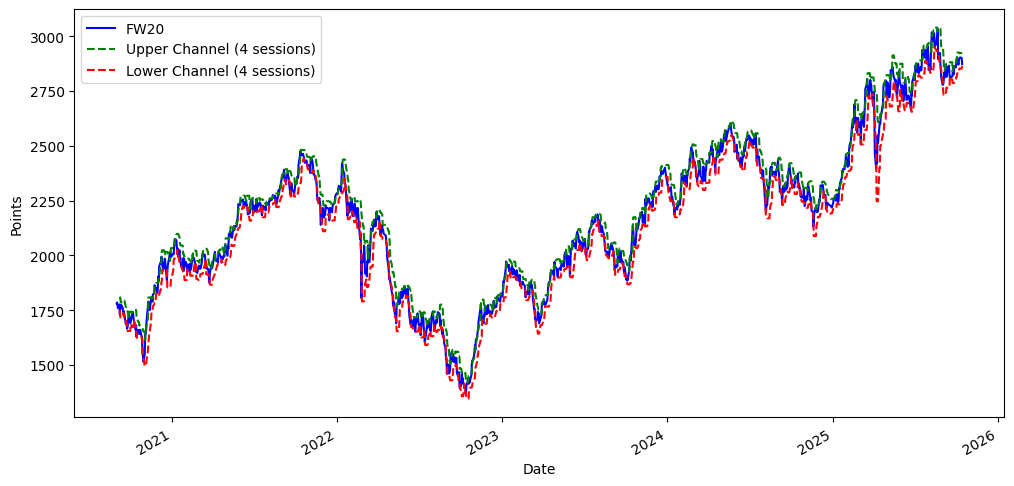

In [12]:
plt.figure(figsize=(12, 6))
df['Close'].plot(label='FW20', color='blue')
df['Upper_Channel'].plot(label=f'Upper Channel ({N_SESSIONS} sessions)', color='green', linestyle='--')
df['Lower_Channel'].plot(label=f'Lower Channel ({N_SESSIONS} sessions)', color='red', linestyle='--')
plt.ylabel('Points')
plt.legend()
plt.show()

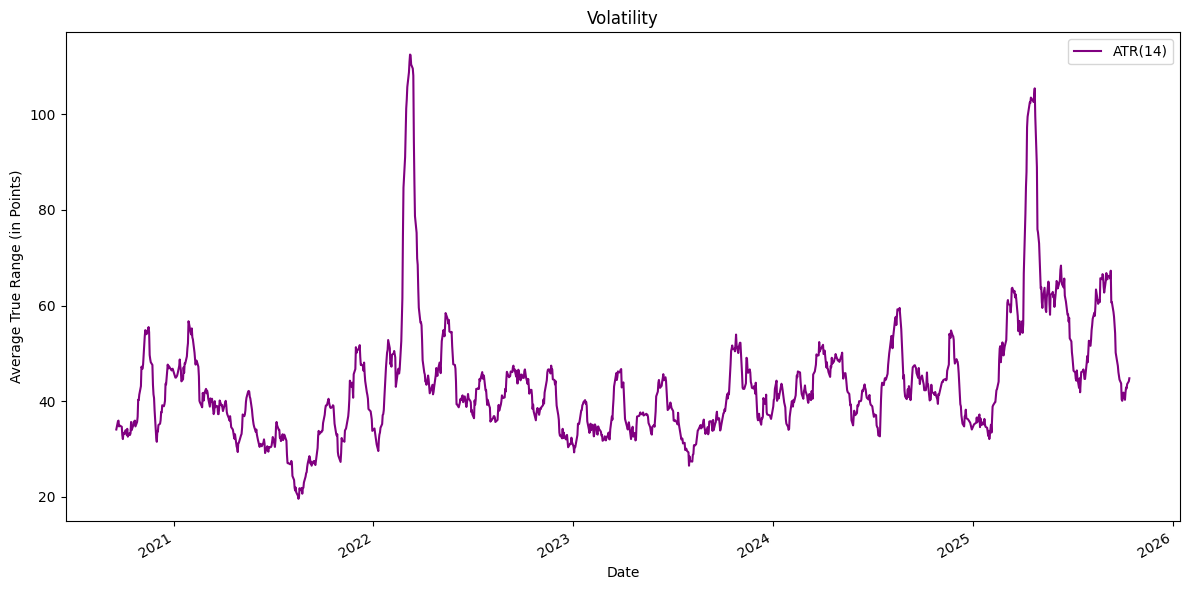

In [13]:
plt.figure(figsize=(12, 6))
# Plot ATR_long
df['ATR_long'].plot(label=f"ATR({ATR_LONG})", color='purple')
# Add labels and legend
plt.title("Volatility")
plt.ylabel("Average True Range (in Points)")
plt.legend()
plt.tight_layout()
plt.show()

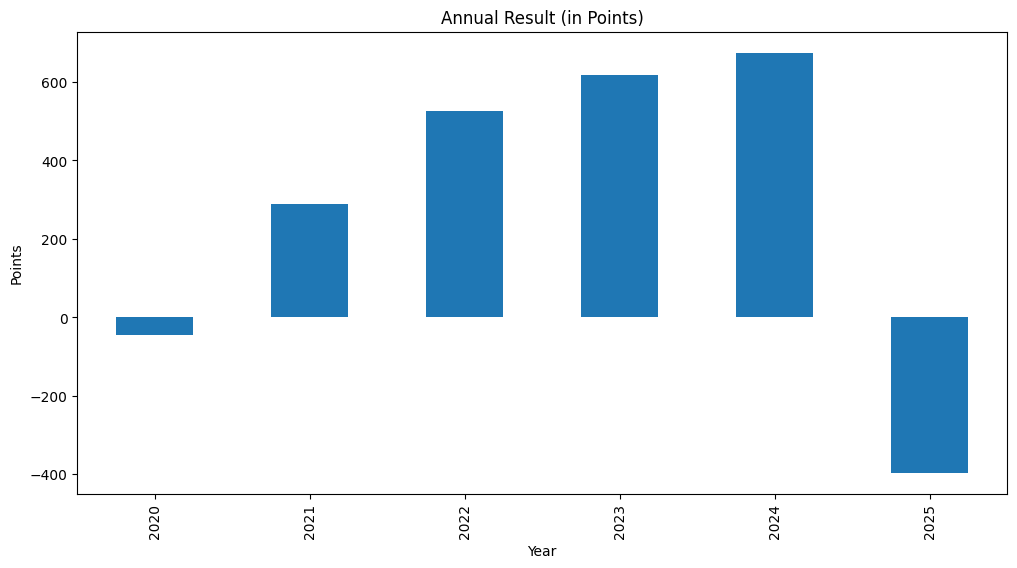

In [14]:
df['Daily_Pts'].groupby(df.index.year).sum().plot(kind='bar', title='Annual Result (in Points)', figsize=(12, 6))
plt.ylabel('Points')
plt.xlabel('Year')
plt.show()

In [15]:
df['Daily_Pts'].groupby(df.index.year).sum()

Date
2020    -45.0
2021    289.0
2022    527.0
2023    619.0
2024    675.0
2025   -396.0
Name: Daily_Pts, dtype: float64

Text(0, 0.5, 'Cumulative Points')

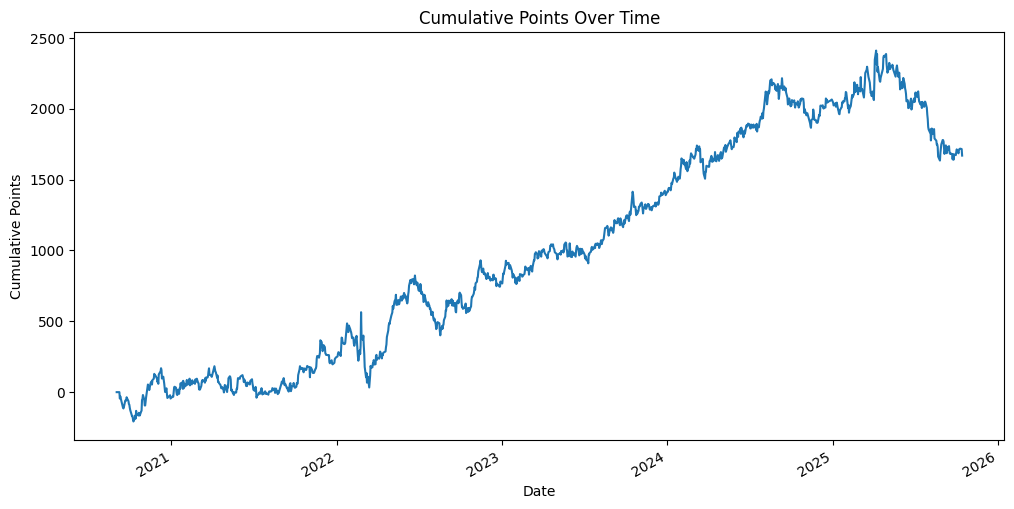

In [16]:
df['Cumulative_Pts'].plot(title='Cumulative Points Over Time', figsize=(12, 6))
plt.ylabel('Cumulative Points')

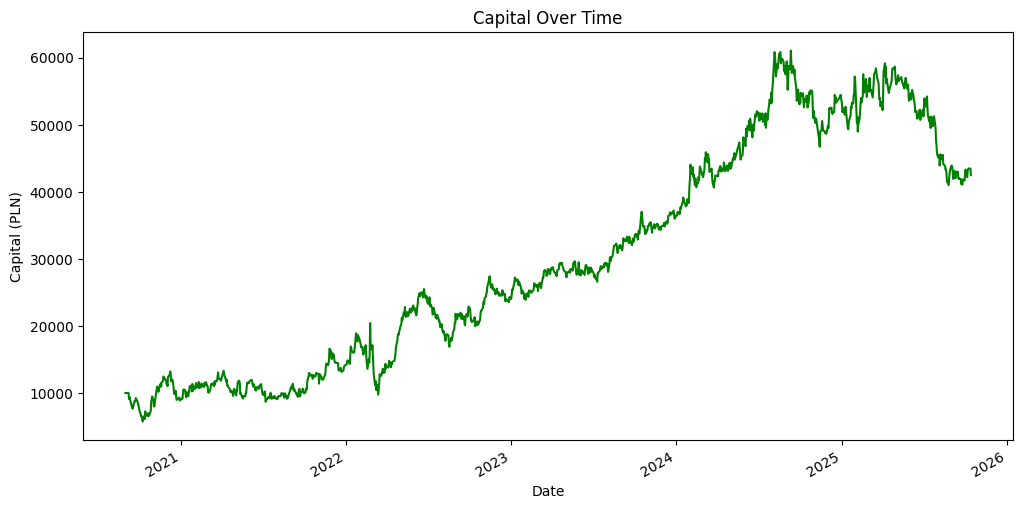

In [17]:
df['Capital'].plot(title='Capital Over Time', figsize=(12, 6), color='green')
plt.ylabel('Capital (PLN)')
plt.show()

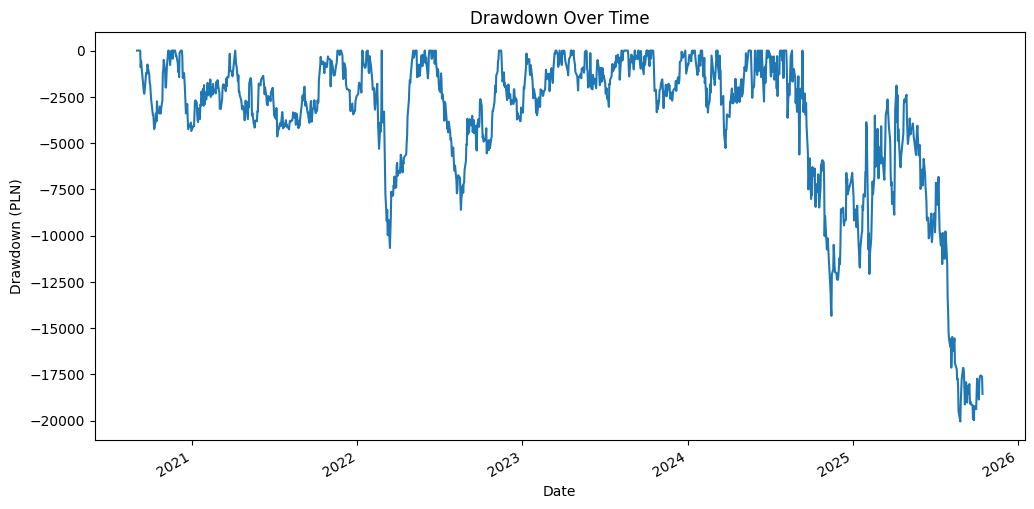

In [18]:
df['Drawdown'].plot(title='Drawdown Over Time', figsize=(12, 6))
plt.ylabel('Drawdown (PLN)')
plt.show()

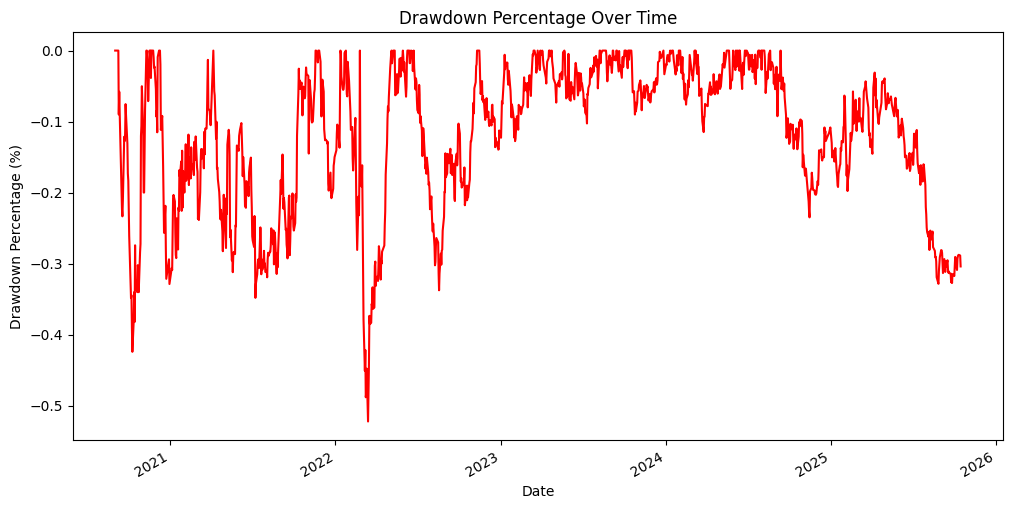

In [19]:
df['Drawdown_Pct'].plot(title='Drawdown Percentage Over Time', figsize=(12, 6), color='red')
plt.ylabel('Drawdown Percentage (%)')
plt.show()

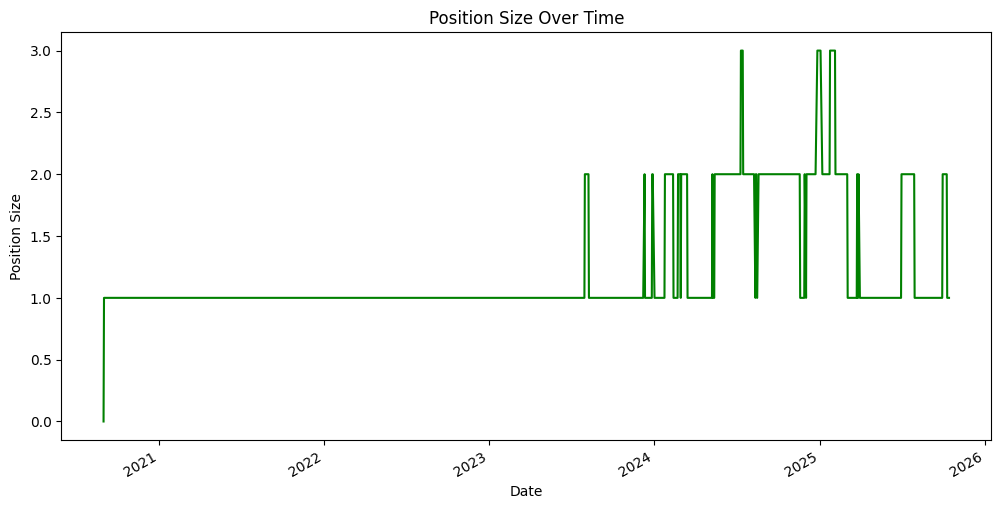

In [20]:
df['Position_Size'].plot(title='Position Size Over Time', figsize=(12, 6), color='green')
plt.ylabel('Position Size')
plt.show()

### Performance Metrics Calculation

In [21]:
trades = []
current_pos = 0
entry_price = None
entry_index = None
pnl = 0

for i in range(1, len(df)):
    row = df.iloc[i]
    prev_row = df.iloc[i - 1]

    # Entry
    if current_pos == 0 and row['Position'] != 0:
        current_pos = row['Position']
        entry_price = row['Entry_Price']
        entry_index = df.index[i]
        pnl = 0

    # Still in position
    elif current_pos != 0 and row['Position'] == current_pos:
        pnl += row['Daily_Pts']

    # Exit or flip
    elif current_pos != 0 and row['Position'] != current_pos:
        # pnl += row['Daily_Pts']
        pnl = (row['Entry_Price'] - prev_row['Entry_Price']) * current_pos
        exit_index = df.index[i]
        trades.append({
            'Entry_Date': entry_index,
            'Exit_Date': exit_index,
            'Position': current_pos,
            'PnL': pnl
        })

        # Start new trade if flipped
        if row['Position'] != 0:
            current_pos = row['Position']
            entry_price = row['Entry_Price']
            entry_index = df.index[i]
            pnl = 0
        else:
            current_pos = 0
            entry_price = None
            entry_index = None
            pnl = 0

In [22]:
trades_df = pd.DataFrame(trades)

In [23]:
total_trades = len(trades_df)

# --- Basic Trade Statistics ---

# Subsets
winning_trades = trades_df[trades_df['PnL'] >= 0]
losing_trades = trades_df[trades_df['PnL'] < 0]

# Counts
no_profitable_trades = len(winning_trades)
no_losing_trades = len(losing_trades)
winrate = no_profitable_trades / total_trades if total_trades > 0 else 0

# Calculate average profit per winning trade
avg_profit = winning_trades['PnL'].mean()

# Calculate average loss per losing trade
avg_loss = losing_trades['PnL'].mean()  # This will be negative

# Calculate payout ratio
if avg_loss != 0:
    payout_ratio = avg_profit / abs(avg_loss)
else:
    payout_ratio = np.nan  # Avoid division by zero

edge = (winrate * payout_ratio) - (1 - winrate)

# --- Risk-Adjusted Performance ---

daily_returns = df['Daily_PnL'] / df['Capital'].shift(1)
negative_returns = daily_returns[daily_returns < 0]

# Sharpe Ratio
sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

# Sortino Ratio
sortino = daily_returns.mean() / negative_returns.std() * np.sqrt(252)

# Drawdowns
max_dd = df['Drawdown'].min()
max_dd_pct = df['Drawdown_Pct'].min()
romad = df['Cumulative_PnL'].iloc[-1] / abs(max_dd) if max_dd != 0 else np.nan

gross_profit = winning_trades['PnL'].sum()
gross_loss = losing_trades['PnL'].sum()
expectancy = (winrate * avg_profit) + ((1 - winrate) * avg_loss)

holding_days = (trades_df['Exit_Date'] - trades_df['Entry_Date']).dt.days
avg_holding_period = holding_days.mean()




In [24]:
num_years = (df.index[-1] - df.index[0]).days / 365.25

final_capital = df['Capital'].iloc[-1]

if num_years > 0 and INITIAL_CAPITAL > 0:
    cagr = (final_capital / INITIAL_CAPITAL) ** (1 / num_years) - 1
else:
    cagr = np.nan



### Performance Metrics

In [25]:
# Print results
print("Start date: ", df.index[0])
print("End date:", df.index[-1])
print("-------------------")
print("Total Trades:", total_trades)
print("Profitable Trades:", no_profitable_trades)
print("Losing Trades:", no_losing_trades)
print("Win Rate:", round(no_profitable_trades / total_trades * 100, 2), "%")
print(f"Average Profit per Trade: {avg_profit:.2f}")
print(f"Average Loss per Trade: {avg_loss:.2f}")
print(f"Payout Ratio: {payout_ratio:.2f}")
print(f"Edge: {edge:.2f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max DD: {max_dd:.2f}")
print(f"Max DD %: {max_dd_pct*100:.2f}%")
print(f"RoMaD: {romad:.2f}")
print(f"Expectancy: {expectancy:.2f}")
print(f"Avg Holding Period: {avg_holding_period:.2f}")
print("-------------------")
print(f"Initial capital: {INITIAL_CAPITAL:,.2f}")
print(f"Final capital: {final_capital:,.2f}")
print(f"CAGR: {cagr*100:.2f}%")

Start date:  2020-09-01 00:00:00
End date: 2025-10-14 00:00:00
-------------------
Total Trades: 168
Profitable Trades: 71
Losing Trades: 97
Win Rate: 42.26 %
Average Profit per Trade: 81.30
Average Loss per Trade: -42.04
Payout Ratio: 1.93
Edge: 0.24
Sharpe Ratio: 0.85
Sortino Ratio: 1.32
Max DD: -20051.00
Max DD %: -52.23%
RoMaD: 1.79
Expectancy: 10.08
Avg Holding Period: 11.08
-------------------
Initial capital: 10,000.00
Final capital: 42,495.00
CAGR: 32.68%


In [26]:
print('Biggest winning trade:')
trades_df.loc[trades_df['PnL'].idxmax()]

Biggest winning trade:


Entry_Date    2022-04-05 00:00:00
Exit_Date     2022-05-13 00:00:00
Position                       -1
PnL                         389.0
Name: 54, dtype: object

In [27]:
print('Biggest losing trade:')
trades_df.loc[trades_df['PnL'].idxmin()]

Biggest losing trade:


Entry_Date    2022-03-03 00:00:00
Exit_Date     2022-03-07 00:00:00
Position                        1
PnL                        -165.0
Name: 51, dtype: object

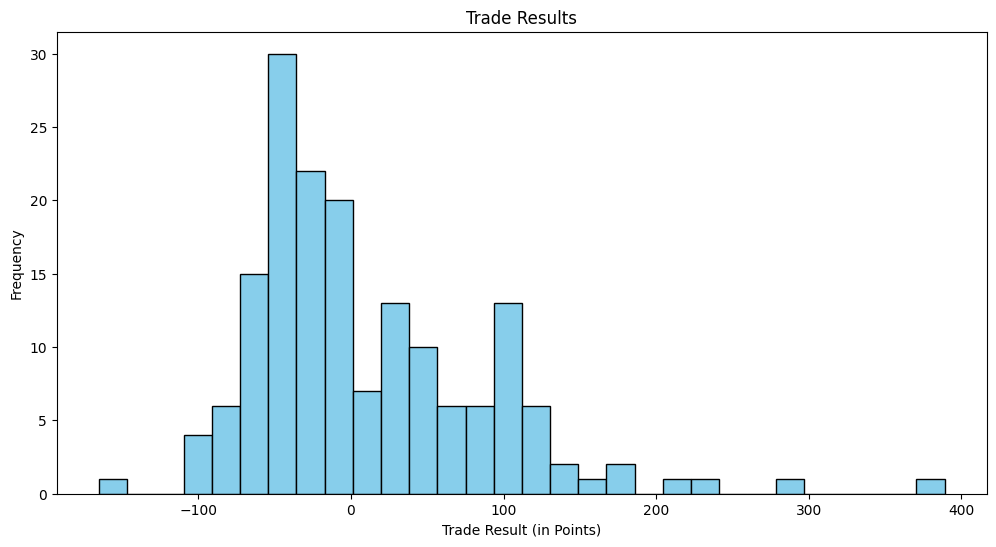

In [28]:
# plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.hist(trades_df['PnL'], bins=30, color='skyblue', edgecolor='black')
plt.title('Trade Results')
plt.xlabel('Trade Result (in Points)')
plt.ylabel('Frequency')
plt.show()

## Current Position

In [29]:
print('Current trade:')
df[['Entry_Price', 'Close', 'Position', 'Position_Size', 'Buy_Level', 'Sell_Level']].iloc[-1]

Current trade:


Entry_Price      2863.0
Close            2872.0
Position           -1.0
Position_Size       1.0
Buy_Level        2924.0
Sell_Level       2863.0
Name: 2025-10-14 00:00:00, dtype: float64